In [1]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers
from keras.callbacks import ReduceLROnPlateau
from keras.layers import LSTM, Activation, Flatten, Dropout, SimpleRNN, Bidirectional, RNN, Conv1D, GRU
import plotly.offline as py
import plotly.graph_objs as go
import numpy as np
import seaborn as sns
py.init_notebook_mode(connected=True)
%matplotlib inline

Using TensorFlow backend.


In [2]:
data = pd.read_csv(filepath_or_buffer="BTCUSDKRAKEN.csv", index_col="Date")
data.head()

,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
Date,,,,,,,
1/7/2014,874.67040,892.06753,810.00000,810.00000,15.622378,13151.472840,841.835522
1/8/2014,810.00000,899.84281,788.00000,824.98287,19.182756,16097.329580,839.156269
1/9/2014,825.56345,870.00000,807.42084,841.86934,8.158335,6784.249982,831.572913
1/10/2014,839.99000,857.34056,817.00000,857.33056,8.024510,6780.220188,844.938794
1/11/2014,858.20000,918.05471,857.16554,899.84105,18.748285,16698.566930,890.671709


In [3]:
btc_trace = go.Scatter(x=data.index, y=data['Weighted Price'], name= 'Price')
py.iplot([btc_trace])

In [4]:
data['Weighted Price'].replace(0, np.nan, inplace=True)
data['Weighted Price'].fillna(method='ffill', inplace=True)

In [5]:
btc_trace = go.Scatter(x=data.index, y=data['Weighted Price'], name= 'Price')
py.iplot([btc_trace])

In [71]:
from sklearn.preprocessing import MinMaxScaler
values = data['Weighted Price'].values.reshape(-1,1)
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [72]:
train_size = int(len(scaled) * 0.7)
test_size = len(scaled) - train_size
train, test = scaled[0:train_size,:], scaled[train_size:len(scaled),:]
print(len(train), len(test))

965 415


In [73]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

In [74]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

964
414


In [75]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [132]:
model = Sequential()
model.add(LSTM(100, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
history = model.fit(trainX, trainY, epochs=300, batch_size=100, validation_data=(testX, testY), verbose=0, shuffle=False)

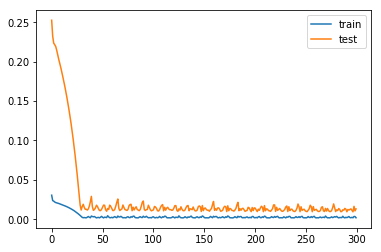

In [133]:
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

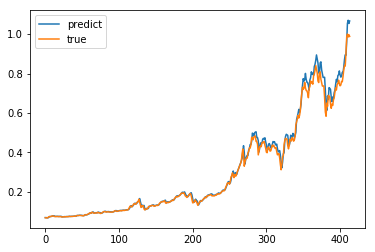

In [134]:
yhat = model.predict(testX)
pyplot.plot(yhat, label='predict')
pyplot.plot(testY, label='true')
pyplot.legend()
pyplot.show()

In [135]:
yhat_inverse = scaler.inverse_transform(yhat.reshape(-1, 1))
testY_inverse = scaler.inverse_transform(testY.reshape(-1, 1))

In [136]:
rmse = sqrt(mean_squared_error(testY_inverse, yhat_inverse))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 128.904


In [185]:
pyplot.plot(yhat_inverse, label='predict')
pyplot.plot(testY_inverse, label='actual', alpha=0.5)
pyplot.legend()
%matplotlib inline
pyplot.show()

In [76]:
predictDates = data.tail(len(testX)).index

In [139]:
predictDates

Index(['8/30/2016', '8/31/2016', '9/1/2016', '9/2/2016', '9/3/2016',
       '9/4/2016', '9/5/2016', '9/6/2016', '9/7/2016', '9/8/2016',
       ...
       '10/8/2017', '10/9/2017', '10/10/2017', '10/11/2017', '10/12/2017',
       '10/13/2017', '10/14/2017', '10/15/2017', '10/16/2017', '10/17/2017'],
      dtype='object', name='Date', length=414)

In [140]:
testY_reshape = testY_inverse.reshape(len(testY_inverse))
yhat_reshape = yhat_inverse.reshape(len(yhat_inverse))

In [141]:
actual_chart = go.Scatter(x=predictDates, y=testY_reshape, name= 'Actual Price')
predict_chart = go.Scatter(x=predictDates, y=yhat_reshape, name= 'Predict Price')
py.iplot([predict_chart, actual_chart])

In [99]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [105]:
#values = data[['Weighted'] + ['Volume (BTC)'] + ['Volume (Currency)']].values
values = data[['Open'] + ['High'] + ['Low'] + ['Close']].values
values = values.astype('float32')

In [106]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [107]:
reframed = series_to_supervised(scaled, 1, 1)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var1(t),var2(t),var3(t),var4(t)
1,0.150805,0.152376,0.145786,0.139655,0.139655,0.153704,0.141826,0.142238
2,0.139655,0.153704,0.141826,0.142238,0.142339,0.148606,0.145322,0.145150
3,0.142339,0.148606,0.145322,0.145150,0.144826,0.146444,0.147046,0.147816
4,0.144826,0.146444,0.147046,0.147816,0.147966,0.156814,0.154275,0.155145
5,0.147966,0.156814,0.154275,0.155145,0.155166,0.153891,0.149925,0.148276


In [108]:
reframed.drop(reframed.columns[[4,5,6]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)   var4(t)
1   0.150805   0.152376   0.145786   0.139655  0.142238
2   0.139655   0.153704   0.141826   0.142238  0.145150
3   0.142339   0.148606   0.145322   0.145150  0.147816
4   0.144826   0.146444   0.147046   0.147816  0.155145
5   0.147966   0.156814   0.154275   0.155145  0.148276


In [121]:
values = reframed.values
n_train_hours = int(len(values) * 0.7)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(965, 1, 4) (965,) (414, 1, 4) (414,)


In [ ]:
def tcn(h,filters=50, kernel_size=3, padding='causal', activation=):
    main = h
    for i in ramge(2):
        main = Conv1D(filters=filters,kernel_size=kerne_size,padding=padding)(main)
        main = Dropout(0.05)(main)
    side_path = Conv1D(filters=filters,kernel_size=1, padding='same')(h)
    return main + side_path
    

In [122]:
from keras.callbacks import ReduceLROnPlateau
multi_model = Sequential()
multi_model.add(GRU(300, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
multi_model.add(GRU(200,dropout=0.1))
multi_model.add(Dense(1))
ad = optimizers.Adam(lr=0.0001)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=1e-6)
multi_model.compile(loss='mae', optimizer=ad)
multi_history = multi_model.fit(train_X, train_y, epochs=300, batch_size=100, callbacks=[reduce_lr],  validation_data=(test_X, test_y), verbose=0, shuffle=False)

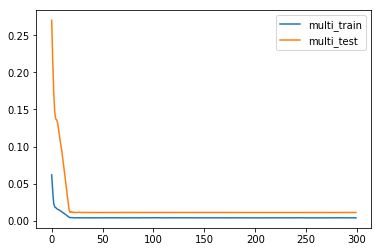

In [123]:
pyplot.plot(multi_history.history['loss'], label='multi_train')
pyplot.plot(multi_history.history['val_loss'], label='multi_test')
pyplot.legend()
pyplot.show()

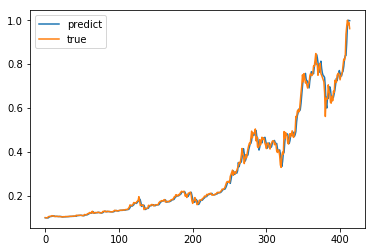

In [124]:
yhat = multi_model.predict(test_X)
pyplot.plot(yhat, label='predict')
pyplot.plot(test_y, label='true')
pyplot.legend()
pyplot.show()

In [228]:
np.concatenate((test_y.reshape(len(test_y),1),yhat),axis=1)

array([[ 0.0998207 ,  0.09809099],
       [ 0.09900345,  0.09829786],
       [ 0.09862069,  0.0981162 ],
       [ 0.0995    ,  0.09776358],
       [ 0.10362069,  0.09772167],
       [ 0.10512759,  0.09945101],
       [ 0.1051507 ,  0.10189963],
       [ 0.10551741,  0.10309027],
       [ 0.10643708,  0.10361122],
       [ 0.10881363,  0.10408133],
       [ 0.10794827,  0.10543992],
       [ 0.10773948,  0.10608137],
       [ 0.10487173,  0.10623676],
       [ 0.10536328,  0.10509458],
       [ 0.10608432,  0.10433608],
       [ 0.10585707,  0.10411224],
       [ 0.10516586,  0.10420538],
       [ 0.10482414,  0.10406745],
       [ 0.10462069,  0.10379986],
       [ 0.10551535,  0.1034646 ],
       [ 0.10503449,  0.10368096],
       [ 0.10410345,  0.10369941],
       [ 0.10338794,  0.10342146],
       [ 0.10259534,  0.10250171],
       [ 0.1041669 ,  0.10188963],
       [ 0.10413776,  0.10198351],
       [ 0.10344793,  0.10245859],
       [ 0.10499655,  0.10233668],
       [ 0.10456983,

In [125]:
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [61]:
np.concatenate((inv_y.reshape(len(inv_y),1),inv_yhat.reshape(len(inv_yhat),1)),axis=1)

array([[  578.98999023,   578.98999023],
       [  573.55200195,   573.55200195],
       [  577.23999023,   577.23999023],
       [  574.21002197,   574.21002197],
       [  572.        ,   572.        ],
       [  576.65301514,   576.65301514],
       [  601.        ,   601.        ],
       [  612.29901123,   612.29901123],
       [  609.63397217,   609.63397217],
       [  613.31799316,   613.31799316],
       [  617.33300781,   617.33300781],
       [  627.08300781,   627.08300781],
       [  625.7800293 ,   625.7800293 ],
       [  624.88897705,   624.88897705],
       [  611.29901123,   611.29901123],
       [  611.10699463,   611.10699463],
       [  612.36999512,   612.36999512],
       [  612.5       ,   612.5       ],
       [  612.91699219,   612.91699219],
       [  610.08300781,   610.08300781],
       [  609.92999268,   609.92999268],
       [  612.94000244,   612.94000244],
       [  611.059021  ,   611.059021  ],
       [  603.10601807,   603.10601807],
       [  598.92

In [126]:
rmse = sqrt(mean_squared_error(inv_y[:-1], inv_yhat[1:]))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 51.741


In [116]:
actual_chart = go.Scatter(x=predictDates, y=inv_y, name= 'Actual Price')
multi_predict_chart = go.Scatter(x=predictDates, y=inv_yhat, name= 'Multi Predict Price')
predict_chart = go.Scatter(x=predictDates, y=yhat_reshape, name= 'Predict Price')
py.iplot([predict_chart, multi_predict_chart, actual_chart])